In [1]:
#необходимые пакеты 
import ee, geemap, os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import scipy

In [2]:
ee.Initialize()

In [3]:
region_boundary = geemap.geojson_to_ee('data/budenovsk_district_boundaries.geojson')

Budenovsk = geemap.Map(zoom = 10)

Budenovsk.centerObject(region_boundary)

Budenovsk.addLayer(region_boundary ,{'color' : "FF0000"}, 'Границы региона' )

Budenovsk

Map(center=[44.745544055004785, 44.14114333519604], controls=(WidgetControl(options=['position'], widget=HBox(…

In [4]:
#геометрии
Archangelskoe = gpd.read_file('data/archangelskoe_wgs84.geojson' )
Praskoveya = gpd.read_file('Data/praskoveya_wgs84.geojson')

Archangelskoe['type'] = 'PP'
Praskoveya['type'] = 'TT'

geometry_df = Praskoveya.append(Archangelskoe.iloc[:,2:])


geometry_df['number'] = [i for i in range(0,geometry_df.shape[0])]

geometry_df_geemap = geemap.geopandas_to_ee(geometry_df)
geometry_df

,id,_mean,culture,name,cultutre19,geometry,type,culture18,culture19,crop2018,crop2019,number
0,21.0,0.067364,пропашная,Прасковейское,par,"POLYGON ((44.25443 44.69242, 44.25624 44.69448...",TT,NaN,NaN,NaN,NaN,0
1,22.0,0.242672,озимая,Прасковейское,None,"POLYGON ((44.29948 44.66839, 44.28994 44.67340...",TT,NaN,NaN,NaN,NaN,1
2,19.0,0.170963,пропашная,Прасковейское,oz.psen.trad,"POLYGON ((44.29994 44.66801, 44.31107 44.67854...",TT,NaN,NaN,NaN,NaN,2
3,20.0,0.166594,пропашная,Прасковейское,oz.psen.trad,"POLYGON ((44.30987 44.66254, 44.32131 44.67360...",TT,NaN,NaN,NaN,NaN,3
4,25.0,0.185554,пропашная,Прасковейское,oz.psen.trad,"POLYGON ((44.32021 44.65721, 44.33200 44.66846...",TT,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.22878 44.55224, 44.22557 44.55407...",PP,oz.yachmen,goroh,NaN,NaN,265
146,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.16633 44.60854, 44.17036 44.60653...",PP,oz.pshenica,podsoln,NaN,NaN,266
147,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.15963 44.62325, 44.16744 44.61913...",PP,oz.pshenica,podsoln,NaN,NaN,267
148,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.12099 44.64406, 44.13320 44.63767...",PP,None,None,NaN,NaN,268


##### MODIS NDVI

In [5]:
MODIS_NDVI = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(region_boundary).filterDate('2018-09-01', '2019-09-01').select('NDVI')

In [6]:

collection_size = MODIS_NDVI.size().getInfo() # размер коллекции

MODIS_NDVI_list = MODIS_NDVI.toList(collection_size)


NDVI_MODIS_COLLECTION = ee.Image().reproject(crs= 'SR-ORG:6974' , crsTransform = [231.656358264,0,-20015109.354,0,-231.656358264,10007554.677])


time_lst = [] # лист с датами NDVI 
print(time_lst)
for i in range(collection_size): 
    img = ee.Image(MODIS_NDVI_list.get(i))
    time = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    
    time_lst.append(time)
    
    img = ee.Image(MODIS_NDVI_list.get(i)).select('NDVI').multiply(0.0001).rename(time)


    NDVI_MODIS_COLLECTION = NDVI_MODIS_COLLECTION.addBands(img) #датафрейм с каналами


    
print(time_lst)

df = NDVI_MODIS_COLLECTION.select(time_lst).sampleRegions(geometry_df_geemap)

#geemap.ee_export_vector(df, filename='C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/NDVI_2018_2019_modis.csv')
#скачиваем датафрейм с данными NDVI

[]
['2018-09-14', '2018-09-30', '2018-10-16', '2018-11-01', '2018-11-17', '2018-12-03', '2018-12-19', '2019-01-01', '2019-01-17', '2019-02-02', '2019-02-18', '2019-03-06', '2019-03-22', '2019-04-07', '2019-04-23', '2019-05-09', '2019-05-25', '2019-06-10', '2019-06-26', '2019-07-12', '2019-07-28', '2019-08-13', '2019-08-29']


In [7]:
NDVI_2018_2019 = pd.read_csv('Data/NDVI_2018_2019_modis.csv')
NDVI_2018_2019 = NDVI_2018_2019.drop(["culture",'name','_mean',"cultutre19", 'id','system:index' ], 1)

Данные готовы
первый шаг это проверить на нормальность 

In [8]:
stat_NDVI = NDVI_2018_2019
stat_NDVI

def norm_test_result(x):
    if scipy.stats.kstest(x, 'norm')[1] < 0.05:
        return('распределение отличается от нормального')
    else:
        return('распределение нормальное')
    
normality = stat_NDVI.groupby(["number",'type']).aggregate([norm_test_result]).reset_index()

In [9]:
for i in range((normality.shape[1])):
    print(normality.iloc[:,i].value_counts())

269    1
84     1
98     1
97     1
96     1
      ..
174    1
173    1
172    1
171    1
0      1
Name: (number, ), Length: 270, dtype: int64
PP    150
TT    120
Name: (type, ), dtype: int64
распределение отличается от нормального    247
распределение нормальное                    23
Name: (2019-01-17, norm_test_result), dtype: int64
распределение отличается от нормального    262
распределение нормальное                     8
Name: (2019-02-18, norm_test_result), dtype: int64
распределение отличается от нормального    243
распределение нормальное                    27
Name: (2019-01-01, norm_test_result), dtype: int64
распределение отличается от нормального    254
распределение нормальное                    16
Name: (2019-02-02, norm_test_result), dtype: int64
распределение отличается от нормального    265
распределение нормальное                     5
Name: (2019-06-10, norm_test_result), dtype: int64
распределение отличается от нормального    260
распределение нормальное            

короче везде не нормальное распределение, можно смело сказать что берем медиану 

In [10]:
median_NDVI = stat_NDVI.groupby(["number",'type' ]).aggregate([np.median]).reset_index()

In [11]:
col_names = []
for i in range(median_NDVI.shape[1]):
    col_names.append((median_NDVI.columns[i][0]))
median_NDVI.columns = col_names
median_NDVI

,number,type,2019-01-17,2019-02-18,2019-01-01,2019-02-02,2019-06-10,2018-11-01,2018-12-03,2019-07-12,...,2019-07-28,2018-09-30,2019-06-26,2019-08-29,2019-03-06,2019-04-07,2019-05-09,2018-12-19,2018-10-16,2018-11-17
0,0,TT,0.04385,0.19470,-0.01610,0.11335,0.20310,0.28960,0.3067,0.19400,...,0.20030,0.35950,0.20410,0.20050,0.21255,0.22900,0.26120,0.08055,0.34215,0.26215
1,1,TT,-0.00600,0.19145,-0.01940,0.19345,0.35410,0.19850,0.2460,0.26060,...,0.27110,0.20230,0.24090,0.33590,0.21610,0.40190,0.81200,0.05255,0.20250,0.21030
2,2,TT,-0.01220,0.19140,-0.01660,0.13510,0.54530,0.20260,0.2465,0.28090,...,0.29660,0.20330,0.27680,0.42240,0.19630,0.29750,0.77330,0.05830,0.19800,0.22430
3,3,TT,-0.01300,0.18560,-0.01895,0.16230,0.55790,0.19395,0.2445,0.27120,...,0.26700,0.21770,0.27940,0.38100,0.19700,0.30180,0.78710,0.06040,0.20180,0.16720
4,4,TT,-0.01420,0.18740,-0.02280,0.16390,0.56890,0.21450,0.2574,0.26050,...,0.25130,0.21050,0.29170,0.35870,0.20610,0.32220,0.82260,0.06010,0.21240,0.13820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,265,PP,-0.02020,0.19070,-0.00540,0.02690,0.32840,0.18910,0.2710,0.23850,...,0.22100,0.20680,0.21720,0.21950,0.20920,0.21530,0.69200,0.04600,0.19220,0.12870
266,266,PP,-0.00500,0.20455,0.00020,0.19235,0.65365,0.21005,0.2235,0.58780,...,0.30920,0.22435,0.62265,0.23690,0.21730,0.23505,0.29380,0.11320,0.21920,0.17885
267,267,PP,0.01740,0.19790,0.00250,0.19390,0.68060,0.19310,0.2080,0.66120,...,0.28040,0.21330,0.70070,0.23370,0.22420,0.21720,0.29890,0.13430,0.21070,0.16840
268,268,PP,0.15980,0.19840,0.00570,0.25745,0.45380,0.21480,0.2367,0.22085,...,0.27695,0.20390,0.26815,0.24050,0.20370,0.28285,0.84155,0.20770,0.19265,0.20185


 хочу сдлеать мгк без зимних месяцев- посмотреть насколько вообще меняется что то 
Сначала можно создать методом гланвых компонент две компоненты
https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb ссылка
https://plotly.com/python/pca-visualization/ тут еще про то как добавить единичные вектора

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#### c зимними месяцами 

array([0.40722058, 0.17193603, 0.14325603, 0.07024568, 0.05157536,
       0.03557035, 0.03265516, 0.02272715, 0.01815203, 0.01265699])

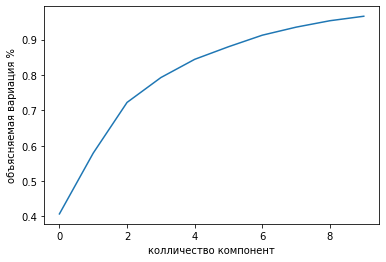

In [13]:
columns_to_pca = col_names[2:]
x = median_NDVI.loc[:,columns_to_pca].values #матрица с значениями NDVI

x = StandardScaler().fit_transform(x) #стандартизация данных

y = median_NDVI.loc[:,["type"]].values
pca = PCA(n_components = 10) #задали колличество компонет
pca.fit(x)
principalComponents = pca.fit_transform(x) # трансформировали датафрейм
principal_NDVI = pd.DataFrame(data = principalComponents , columns = [("PC_" + str(i)) for i in range(1,11) ]) #создали датасет
principal_NDVI['type'] = y
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('колличество компонент')
plt.ylabel('объясняемая вариация %')

pca.explained_variance_ratio_

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

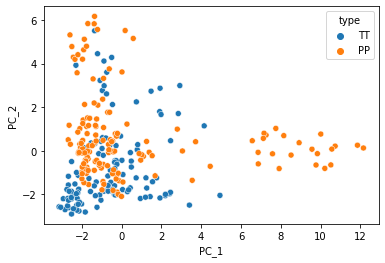

In [14]:
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = 'type', data = principal_NDVI)

### без зимних месяцев 

In [15]:
median_NDVI_nowinter = median_NDVI.loc[:,columns_to_pca][median_NDVI.loc[:,columns_to_pca] >0.1].dropna(axis='columns')
median_NDVI_nowinter[["number",'type']] = median_NDVI[["number",'type']]


array([0.44951909, 0.20296823, 0.16411752, 0.07665128, 0.04130876,
       0.01930612, 0.01171503, 0.00829559, 0.00595186, 0.00507736])

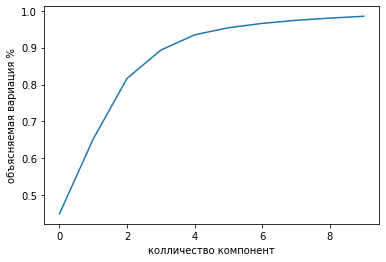

In [16]:
x_NOwinter = median_NDVI_nowinter.iloc[:,:-2].values 

x_NOwinter = StandardScaler().fit_transform(x_NOwinter) #стандартизация данных


y_NOwinter = median_NDVI_nowinter.loc[:,["type"]].values
pca_NOwinter = PCA(n_components = 10) #задали колличество компонет
pca_NOwinter.fit(x_NOwinter)
principalComponents_pca_NOwinter = pca_NOwinter.fit_transform(x_NOwinter) # трансформировали датафрейм
principal_NDVI_NOwinter = pd.DataFrame(data = principalComponents_pca_NOwinter , columns = [("PC_" + str(i)) for i in range(1,11) ]) #создали датасет
principal_NDVI_NOwinter['type'] = y_NOwinter
plt.plot(np.cumsum(pca_NOwinter.explained_variance_ratio_))
plt.xlabel('колличество компонент')
plt.ylabel('объясняемая вариация %')
pca_NOwinter.explained_variance_ratio_

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

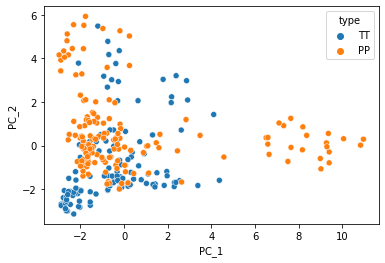

In [17]:
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = 'type', data = principal_NDVI_NOwinter)

разницы что с зимой что без зимы нет 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting
import matplotlib.style
import matplotlib as mpl  # to customise all the components in the graph, including font, size, markers, lines, labels etc
import matplotlib.gridspec as gridspec  # to make sure suptitle is not overlapping with title


# K-means

In [19]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

### для ТТ

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

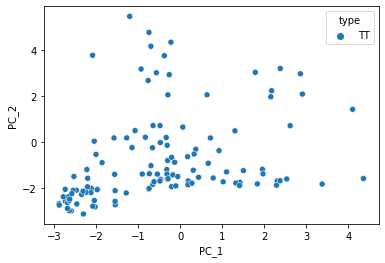

In [20]:
TRAD_PCA = principal_NDVI_NOwinter[principal_NDVI_NOwinter.type == 'TT']
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = 'type', data = TRAD_PCA)

<ipython-input-21-030ea79fb57d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TRAD_PCA[('number_clusteters' + str(k))] = km.labels_
<ipython-input-21-030ea79fb57d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Traditional[('number_clusteters' + str(k))] = km.labels_
<ipython-input-21-030ea79fb57d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

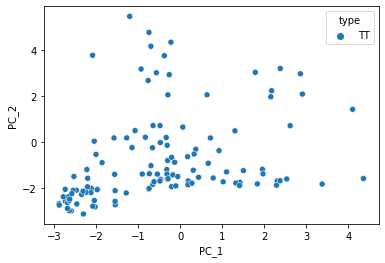

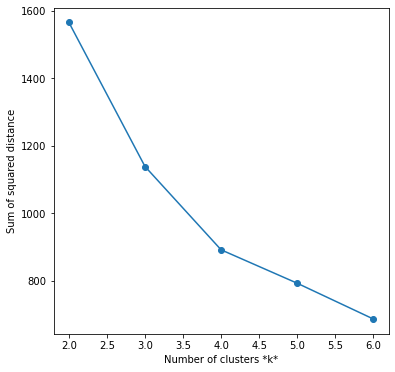

In [21]:
TRAD_PCA = principal_NDVI_NOwinter[principal_NDVI_NOwinter.type == 'TT']
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = 'type', data = TRAD_PCA)

Traditional  = median_NDVI_nowinter[median_NDVI_nowinter['type'] == 'TT'] #выборка только с традиционной
x = StandardScaler().fit_transform(Traditional.iloc[:,:-2]) #стандартизация
list_k = list(range(2, 7)) #колличество кластеров
sse = [] #сумма квадратов расстояния
for k in list_k:
    km = KMeans(n_clusters = k , max_iter = 5000)
    km.fit(x) #он стандартизован выше!
    sse.append(km.inertia_)
    TRAD_PCA[('number_clusteters' + str(k))] = km.labels_
    Traditional[('number_clusteters' + str(k))] = km.labels_
    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');






In [22]:
Traditional.columns[:20]

Index(['2019-02-18', '2019-06-10', '2018-11-01', '2018-12-03', '2019-07-12',
       '2019-08-13', '2018-09-14', '2019-03-22', '2019-04-23', '2019-05-25',
       '2019-07-28', '2018-09-30', '2019-06-26', '2019-08-29', '2019-03-06',
       '2019-04-07', '2019-05-09', '2018-10-16', '2018-11-17', 'number'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

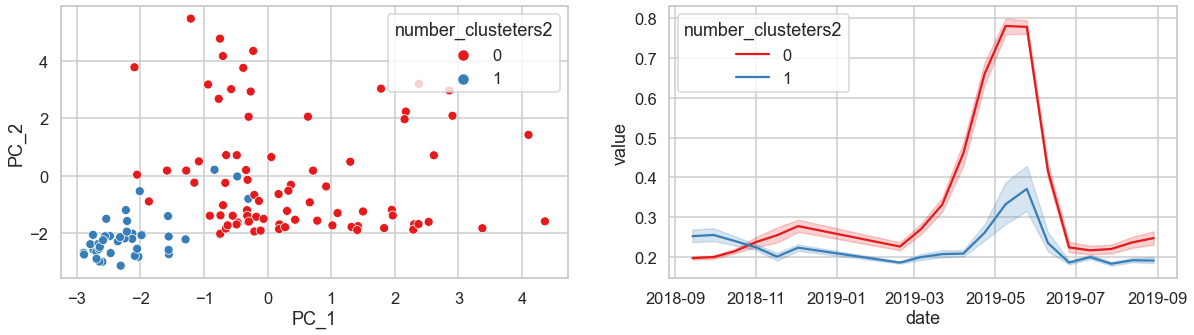

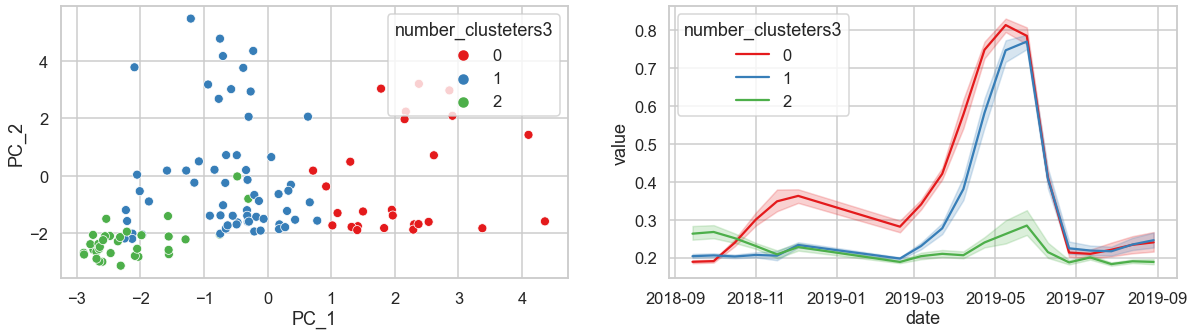

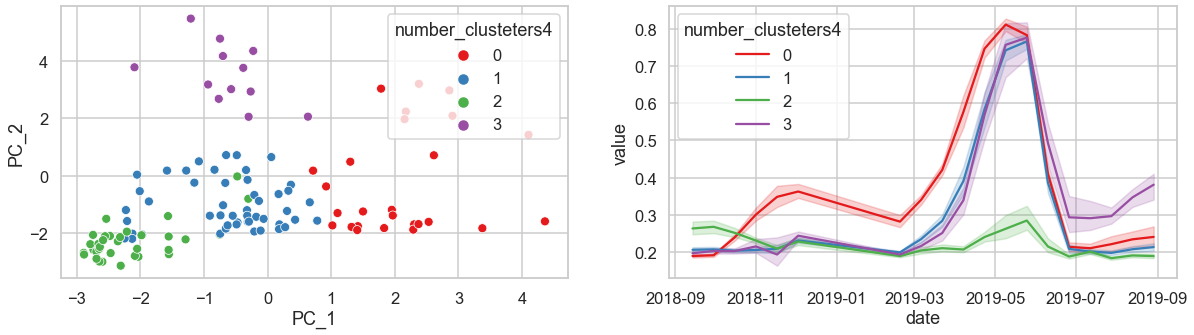

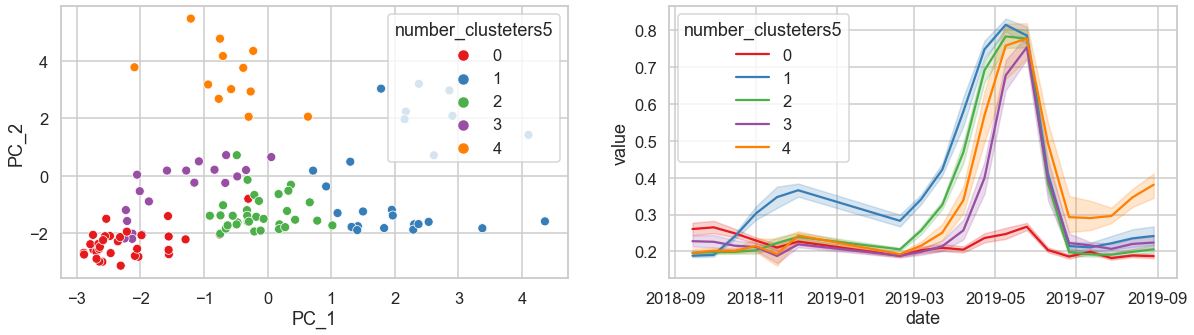

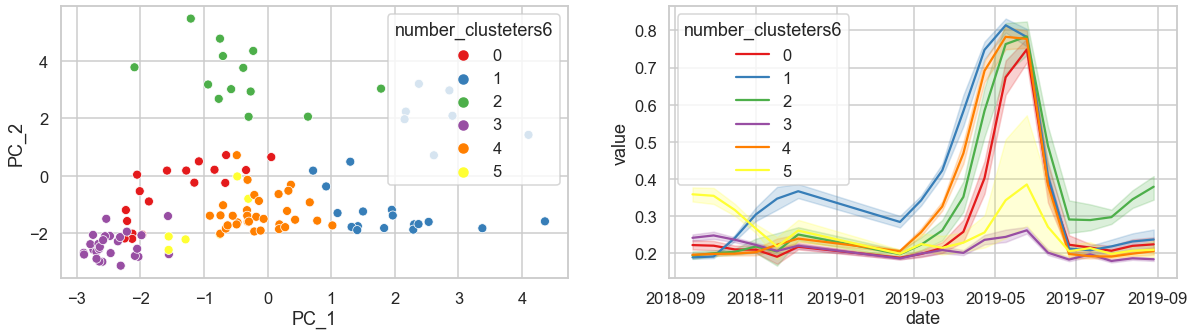

In [24]:
Traditional_date = Traditional.melt(id_vars = ['number', 'type',
       'number_clusteters2', 'number_clusteters3', 'number_clusteters4',
       'number_clusteters5', 'number_clusteters6'], value_vars = Traditional.columns[:19], var_name = 'date')
Traditional_date.date = pd.to_datetime(Traditional_date.date)

for i in range(2, 7):
    sns.set_context("talk")
    sns.set_style("whitegrid")
    


    plt.figure(i)
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(20, 5)
    scater = sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = ('number_clusteters'+str(i)), data = TRAD_PCA, palette='Set1', ax=axs[0])
    date_time =    sns.lineplot(x="date", y="value", hue = ('number_clusteters'+str(i)), data = Traditional_date, palette='Set1', ax=axs[1])

# Для ПП

<ipython-input-25-ee9065c8468b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NO_TILL_PCA[('number_clusteters' + str(k))] = km.labels_
<ipython-input-25-ee9065c8468b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NO_TILL[('number_clusteters' + str(k))] = km.labels_
<ipython-input-25-ee9065c8468b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

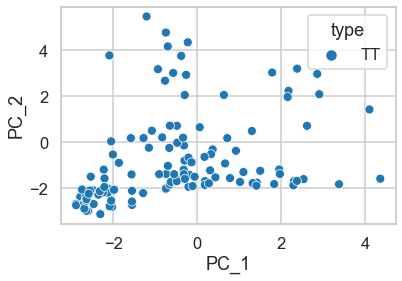

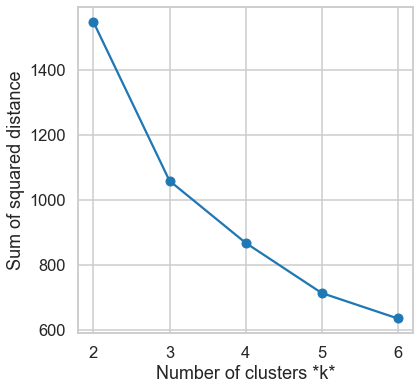

In [25]:
NO_TILL_PCA = principal_NDVI_NOwinter[principal_NDVI_NOwinter.type == 'PP']
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = 'type', data = TRAD_PCA)

NO_TILL  = median_NDVI_nowinter[median_NDVI_nowinter['type'] == 'PP'] #выборка только с традиционной
x = StandardScaler().fit_transform(NO_TILL.iloc[:,:-2]) #стандартизация
list_k = list(range(2, 7)) #колличество кластеров
sse = [] #сумма квадратов расстояния
for k in list_k:
    km = KMeans(n_clusters = k , max_iter = 5000)
    km.fit(x) #он стандартизован выше!
    sse.append(km.inertia_)
    NO_TILL_PCA[('number_clusteters' + str(k))] = km.labels_
    NO_TILL[('number_clusteters' + str(k))] = km.labels_
    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');



<Figure size 432x288 with 0 Axes>

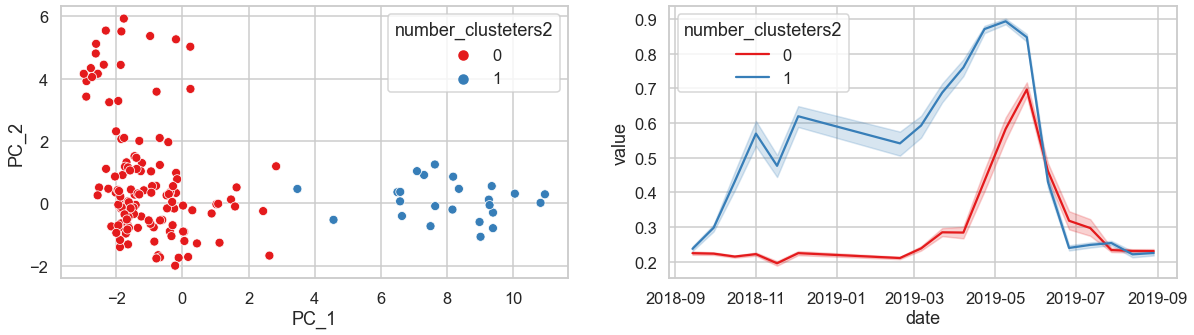

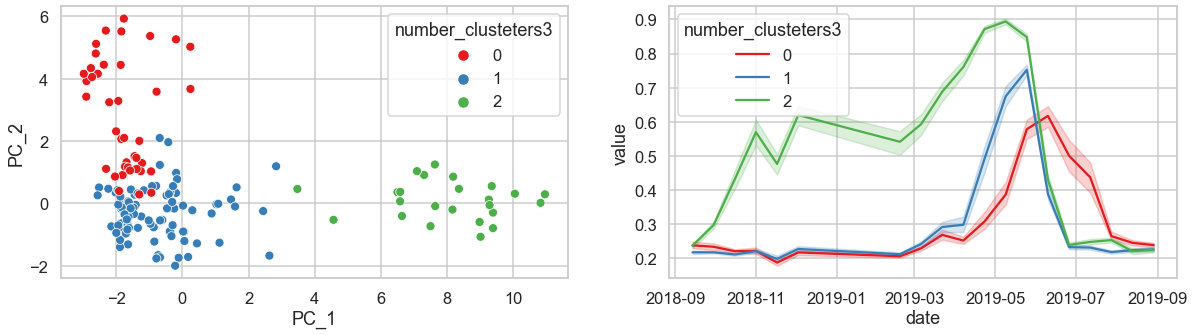

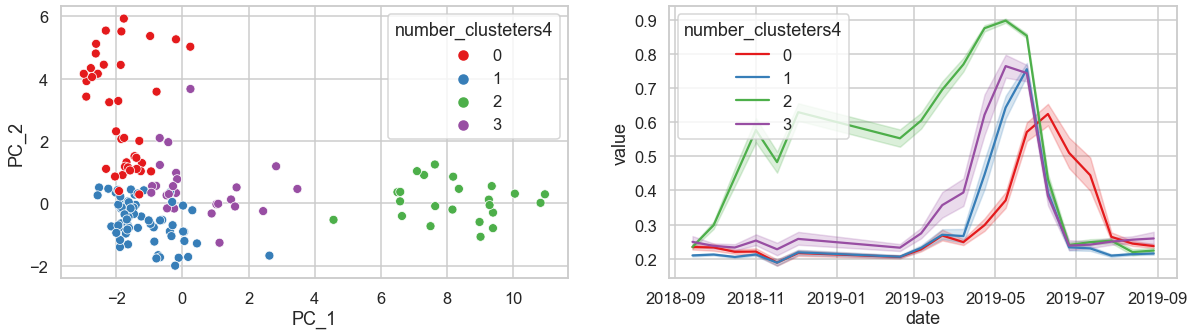

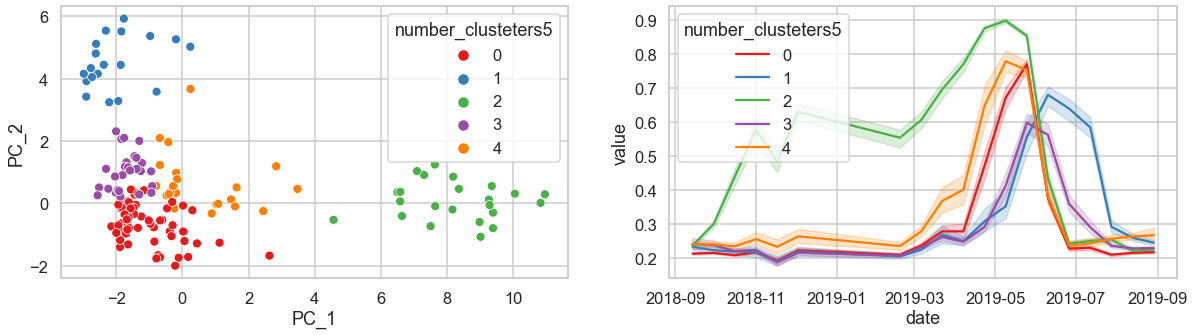

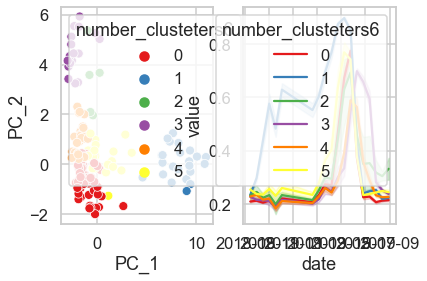

In [26]:
NO_TILL_date = NO_TILL.melt(id_vars = ['number', 'type',
       'number_clusteters2', 'number_clusteters3', 'number_clusteters4',
       'number_clusteters5', 'number_clusteters6'], value_vars = NO_TILL.columns[:19], var_name = 'date')
NO_TILL_date.date = pd.to_datetime(NO_TILL_date.date)

for i in range(2, 7):
    sns.set_context("talk")
    sns.set_style("whitegrid")
    fig.set_size_inches(20, 5)


    plt.figure(i)
    fig, axs = plt.subplots(ncols=2)

    scater = sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = ('number_clusteters'+str(i)), data = NO_TILL_PCA, palette='Set1', ax=axs[0])
    date_time =    sns.lineplot(x="date", y="value", hue = ('number_clusteters'+str(i)), data = NO_TILL_date, palette='Set1', ax=axs[1])

In [27]:
NO_TILL_WITH_CROP = geometry_df[geometry_df['type'] == "PP"].join(NO_TILL, on = ['number'],how='left', lsuffix='_left')

# ТЕПЕРЬ прямой посев с культурами

In [28]:
NO_TILL_WITH_CROP.culture19.unique()

array(['goroh', 'oz.pshenica', 'nut', 'oz.yachmen', 'podsoln', 'len',
       'gorchica', None], dtype=object)

<Figure size 432x288 with 0 Axes>

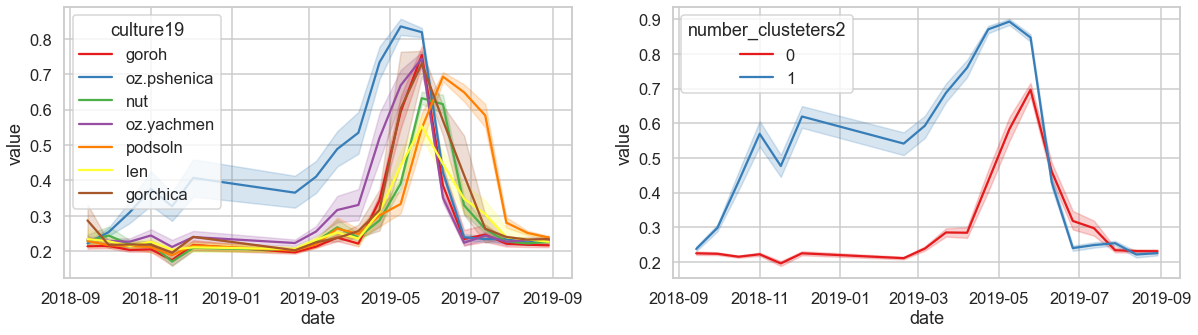

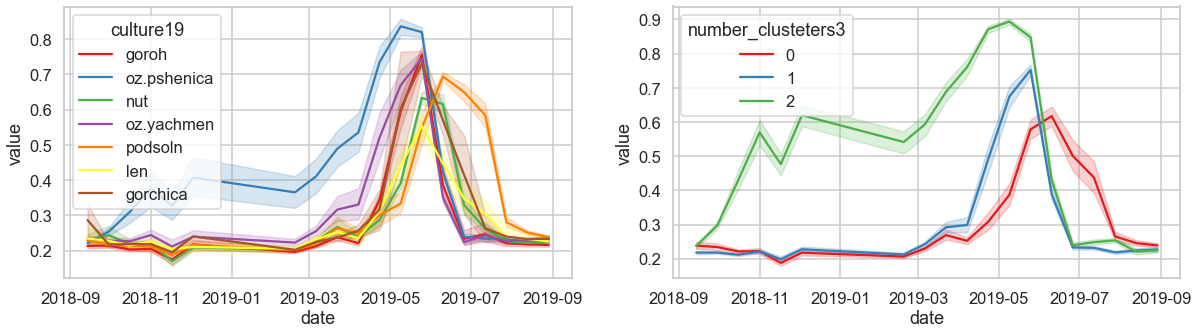

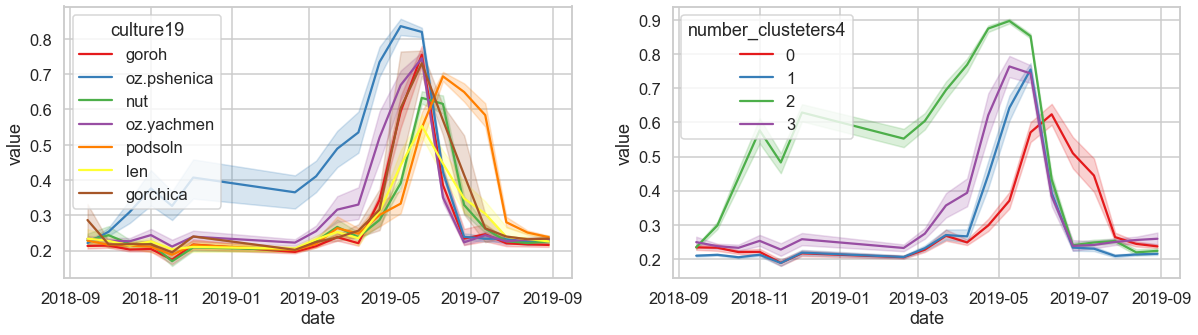

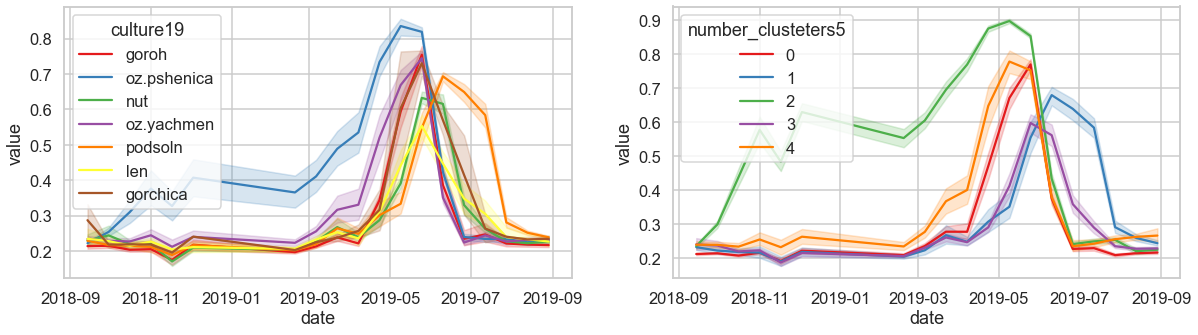

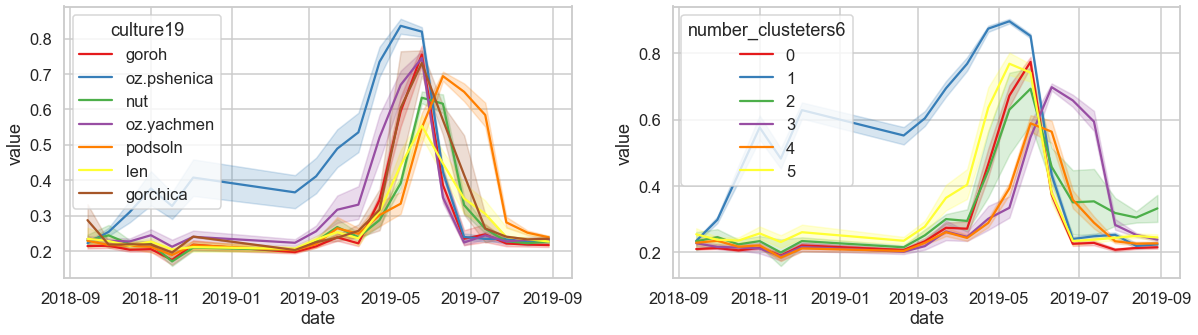

In [29]:
NO_TILL_WITH_CROP_DATE = NO_TILL_WITH_CROP.melt(id_vars = ['number',"culture19", 'type',
       'number_clusteters2', 'number_clusteters3', 'number_clusteters4',
       'number_clusteters5', 'number_clusteters6'], value_vars = NO_TILL.columns[:19], var_name = 'date')
NO_TILL_WITH_CROP_DATE.date = pd.to_datetime(NO_TILL_WITH_CROP_DATE.date)


sns.set_context("talk")
sns.set_style("whitegrid")
fig.set_size_inches(20, 5)
for i in range(2, 7):
    


    plt.figure(i)
    fig, axs = plt.subplots(ncols=2)

    crop = sns.lineplot(x="date", y="value", hue = ("culture19"), data = NO_TILL_WITH_CROP_DATE, palette='Set1', ax=axs[0])
    date_time =    sns.lineplot(x="date", y="value", hue = ('number_clusteters'+str(i)), data = NO_TILL_date, palette='Set1', ax=axs[1])
    fig.set_size_inches(20, 5)

In [35]:
NO_TILL_PCA['real_culture19'] = NO_TILL_WITH_CROP['culture19']

<ipython-input-35-eeccfe252a5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NO_TILL_PCA['real_culture19'] = NO_TILL_WITH_CROP['culture19']


# ИТОГИ

In [60]:
NO_TILL_WITH_CROP['groups'] = NO_TILL_WITH_CROP.number_clusteters3.replace({0: 'не_злаковые_яровые', 1 : 'яровые', 2 : 'озимые'})

Traditional['groups'] = Traditional.number_clusteters3.replace({0: 'озимые', 1 : 'яровые', 2 : 'пары'})

<ipython-input-60-69e27cf4eae1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Traditional['groups'] = Traditional.number_clusteters3.replace({0: 'озимые', 1 : 'яровые', 2 : 'пары'})


In [66]:
cluster_data_frame = Traditional.append(NO_TILL_WITH_CROP)
cluster_data_frame.columns

Index(['2019-02-18', '2019-06-10', '2018-11-01', '2018-12-03', '2019-07-12',
       '2019-08-13', '2018-09-14', '2019-03-22', '2019-04-23', '2019-05-25',
       '2019-07-28', '2018-09-30', '2019-06-26', '2019-08-29', '2019-03-06',
       '2019-04-07', '2019-05-09', '2018-10-16', '2018-11-17', 'number',
       'type', 'number_clusteters2', 'number_clusteters3',
       'number_clusteters4', 'number_clusteters5', 'number_clusteters6',
       'groups', 'id', '_mean', 'culture', 'name', 'cultutre19', 'geometry',
       'type_left', 'culture18', 'culture19', 'crop2018', 'crop2019',
       'number_left'],
      dtype='object')

In [70]:
cluster_data_frame = cluster_data_frame[['2019-02-18', '2019-06-10', '2018-11-01', '2018-12-03', '2019-07-12',
       '2019-08-13', '2018-09-14', '2019-03-22', '2019-04-23', '2019-05-25',
       '2019-07-28', '2018-09-30', '2019-06-26', '2019-08-29', '2019-03-06',
       '2019-04-07', '2019-05-09', '2018-10-16', '2018-11-17','number','groups','type']]
cluster_data_frame[['PC_1_45%', "PC_2_20%","PC_3_16%" ]] = principal_NDVI_NOwinter[["PC_1", "PC_2", "PC_3"]]

In [77]:
RESULT_CLUSTER_NDVI_DATA  = cluster_data_frame.merge(geometry_df[['geometry', "number"]], on =  "number")
RESULT_CLUSTER_NDVI_DATA.to_csv('Data/RESULT_CLUSTER_NDVI_DATA.csv')